In [1]:
using SBMLToolkit, ModelingToolkit, DifferentialEquations, StochasticDiffEq
using Plots
using DataFrames
using CSV
using Random
using Distributions
using SBML
using SymbolicUtils
using StaticArrays
using Catalyst
using AdvancedMH
using MCMCChains
using MCMCChainsStorage
using AbstractMCMC
using StatsPlots
using HDF5
using NPZ

using Particles
using ParticlesDE
using StaticDistributions

base_dir = dirname(dirname(pwd()))

include(joinpath(base_dir, "code/utils/utilities.jl"))
include(joinpath(base_dir, "code/epmodels/utils/posEM.jl"))

## SIR-model filter
In this notebook we evaluate the PMMH algorithm for the standard SIR-model and investigate the results.

In [2]:
# import the model simulator
model_file = joinpath(base_dir, "code/epmodels/sir_model.jl")
include(model_file)

SIR_Model_Ensemble_Simulation (generic function with 1 method)

In [3]:
# SIR-model settings and parameters
N = 180000
init_I = 1800
init_S = N - init_I
u0 = [init_S/N; init_I/N]

endtime = 100.0
tspan = (0.0, endtime)

# define SDe problem
SDE_problem = SIR_SDEProblem(nothing, N, endtime=endtime, initial_state=u0);

In [10]:
# simulate sde problem
solve_kwargs = (dt=1e-2, dense=true, force_dtmin=true)

sde_sol = solve(SDE_problem, PositiveEM(); solve_kwargs...);

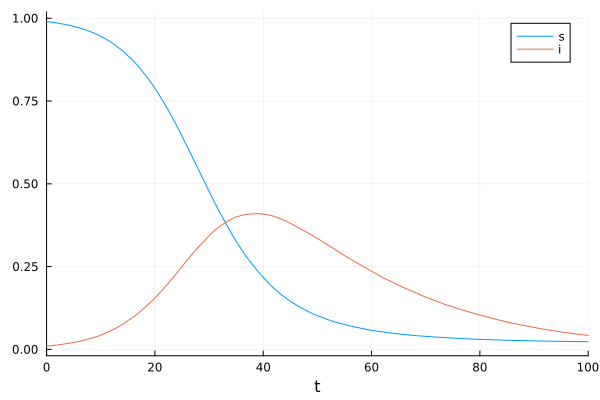

In [11]:
plot(sde_sol)

# Inference

Description of what is stored where?

## Evaluate Particle number

In [17]:
# get data and define observation model
nobs = 2

# load data and observation settings
data_df = CSV.read(base_dir * "/data/sir_dense_normal_and_binomial_1.csv", DataFrame) # cluster
# print(data_df)
infc_counts = data_df[!, "infection count"]
prev_counts = data_df[!, "seroprev"]

real_data = [[infc_counts[i], prev_counts[i]] for i in eachindex(infc_counts)]
real_data = collect(SVector{nobs, Union{Float64, Missing}}, real_data)

# set observation timepoints
tobs = data_df[!, "timepoint"]
# add initial missing
if tobs[1] != 0.0
    real_data = vcat(missing, real_data)
end;
# observation noise
noise_infc = data_df[!, "Std"]
noise_prev = data_df[!, "std"]

# load model
include("SIRNormalFilterSetup.jl")

In [18]:
nruns = 100
nparticles = [10, 50, 100, 200]

theta = [0.1; 0.05]

x = Vector{String}(undef, length(nparticles) * nruns)
y = Vector{Float64}(undef, length(nparticles) * nruns)
variances = Vector{Float64}(undef, length(nparticles))
k = 1
i = 1

for n in nparticles
    logp = log_posterior(n)
    for _ in 1:nruns
        @inbounds x[k] = string(convert(Int, n))
        @inbounds y[k] = logp(theta)
        k += 1
    end
    variances[i] = round(var(y[((i-1)*nruns+1):i*nruns]); digits=3)
    i += 1
end

plt_df = DataFrame(nparticles=x, logp=y);

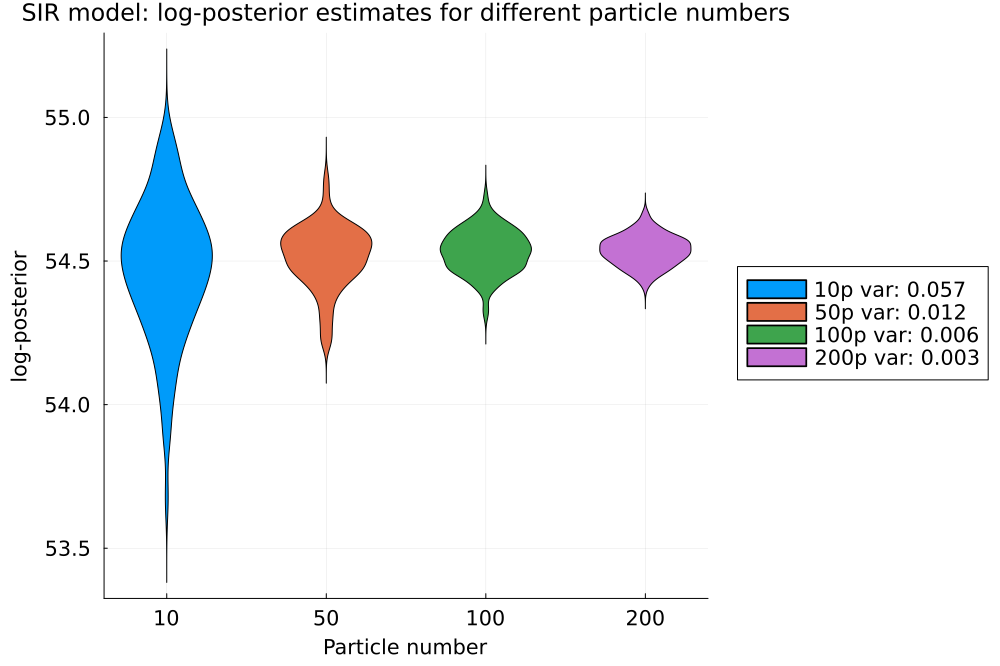

"/home/vincent/PhD/Projects/inference_for_stochastic_systems/Inference-Methods-for-Stochastic-Compartmental-Models/figures/sir_logp_vs_nparticles_example.png"

In [ ]:
using Plots.PlotMeasures

x = plt_df.nparticles
y = plt_df.logp
y = reshape(y, (nruns,length(nparticles)))
x_names = reshape(string.(nparticles), (1,length(nparticles)))
labels_list = ["$(nparticles[j])p var: $(variances[j])" for j in 1:length(nparticles)] 
labels = reshape(labels_list, (1,length(nparticles)))

width_px = 1000
plt = Plots.violin(x_names, y, xlabel="Particle number", ylabel="log-posterior",
        trim=false, labels=labels, legend=:outerright,
        size=(width_px, width_px*2/3), left_margin=20px, bottom_margin=15px,
        guidefont=font(14), titlefont=font(16), labelfont=font(14), xtickfont=font(14), legendfont=font(14), ytickfont=font(14))
plot!(plt, title="SIR model: log-posterior estimates for different particle numbers")
display(plt)

# savefig(plt, joinpath(base_dir, "figures/sir_logp_vs_nparticles_example.png"))

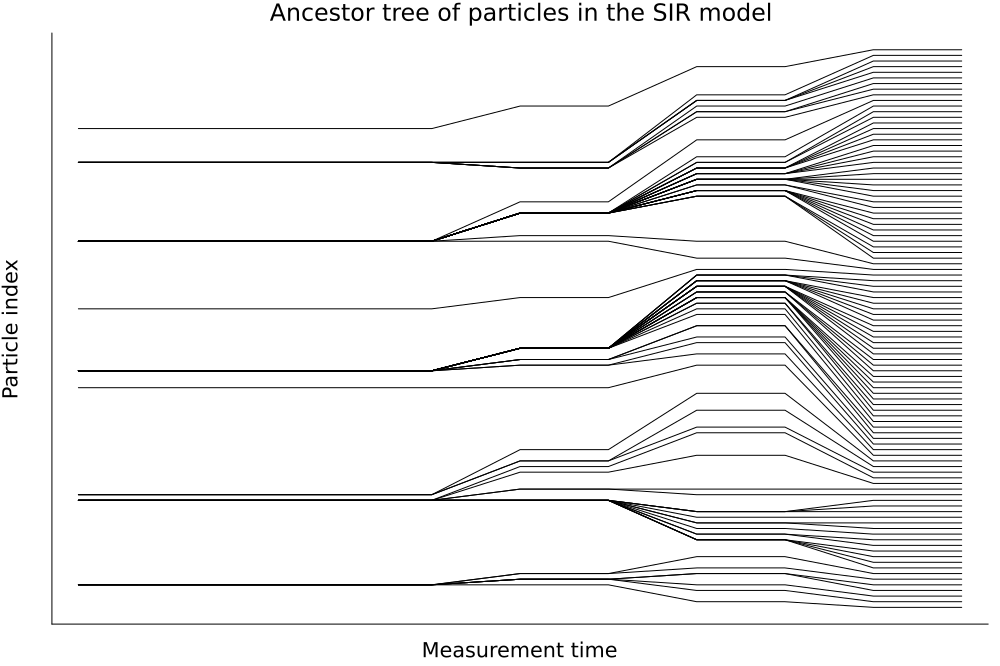

[9, 9, 9, 9, 9, 21, 21, 50, 50, 100, 100]

"/home/vincent/PhD/Projects/inference_for_stochastic_systems/Inference-Methods-for-Stochastic-Compartmental-Models/figures/sir_ancestor_tree_example.png"

In [ ]:
# define and run one instance of the Bootstrap Filter
ssm = SDEStateSpaceModel(SDE_problem, initial_state, fobs, nobs, tobs, solve_alg; solve_kwargs...);

bf = BootstrapFilter(ssm, real_data)
pf = SMC(bf, [0.11, 0.05], 100, ParticleHistoryLength(; didresample=FullHistory(), ancestors=FullHistory(),
                                                                        logCnorm=StaticFiniteHistory{1}()),
            AdaptiveResampling(SystematicResampling(),0.5),);
offlinefilter!(pf);

# print the path of particles ancestors as a genealogical tree
print(unique_ancestors_at_previous_times(pf.history_pf.ancestors))
ptree = plot_ancestor_tree(pf.history_pf.ancestors)
plot!(ptree, title="Ancestor tree of particles in the SIR model", xlabel="Measurement time", ylabel="Particle index")
plot!(ptree, size=(1000,666), left_margin=25px, bottom_margin=15px)
plot!(ptree, guidefont=font(14), titlefont=font(16), labelfont=font(14))
display(ptree)
# savefig(ptree, joinpath(base_dir, "figures/sir_ancestor_tree_example.png"))

## Evaluation of results

In [34]:
include(joinpath(base_dir, "code/utils/EvaluateParticleFilter.jl"))

MCMC_diagnostics (generic function with 1 method)

### Synthetic dense data

In [77]:
# filter settings
nparticles=100
nchains = 4
niter = 50000

# set noise model
noise_model ="normal"

# set experiment id
ex_id = 1

#set prior
prior = "normal";

In [78]:
# set dataset 
datasets = ["1", "2"]
dataset = datasets[ex_id]

# SIR-model settings and parameters
N = 180000
init_I = 1800
init_S = N - init_I
u0 = [init_S/N; init_I/N]

endtime = 100.0
tspan = (0.0, endtime)

# define SDe problem
SDE_problem = SIR_SDEProblem(nothing, N, endtime=endtime, initial_state=u0);

# parameters are in the ordering [beta, gamma]
true_pars = [
    [0.1, 0.05], 
    [0.22, 0.2]]
true_par = true_pars[parse(Int, dataset)]

# get true parameter dictionary
true_par_dict = Dict(
    :beta => true_par[1],
    :gamma => true_par[2];)

Dict{Symbol, Float64} with 2 entries:
  :beta  => 0.1
  :gamma => 0.05

In [79]:
# load results
chain = h5open(joinpath(base_dir, "output/ParticleFilter/SIR_$(dataset)_$(nchains)chs_$(niter)it_$(nparticles)p.h5"), "r") do f
    read(f, Chains)
 end
chain_time = open(joinpath(base_dir, "output/ParticleFilter/time_SIR_$(dataset)_$(nchains)chs_$(niter)it_$(nparticles)p.txt"), "r") do f
    read(f, Float64)
end
chain = setinfo(chain, (start_time=0.0, stop_time=chain_time));

if niter > 10000
    burnin = Int(niter-10000)
else
    burnin = Int(niter/10)
end
    
mixed_chain = chain[burnin:end]

# check which chain is converged and remove stuck chains.
nparams = length(names(mixed_chain))
stuck_flags = Bool[]
for c in 1:nchains
    chain_slice = mixed_chain[:, :, c]
    n_samples = size(chain_slice, 1)
    last_samples = chain_slice[:, :, 1]
    # Collect quantiles for each parameter
    q_by_param = [quantile(vec(last_samples[:, param, :]), [0.05, 0.5, 0.95]) for param in names(mixed_chain)[2:end]]
    # Check if all quantiles are equal across parameters (i.e. chain not moving)
    all_same = all(q -> all(abs.(q[1] .- q[2:end]) .< 1e-10), q_by_param)
    push!(stuck_flags, all_same)
end
mixed_chain = mixed_chain[:,:, findall(!, stuck_flags)]

if size(mixed_chain, 3) == 0
   error("All chains got stuck! No usable chains remain.")
end
mixed_chain

Chains MCMC chain (10002×3×4 Array{Float64, 3}):

Iterations        = 40000:1:50001
Number of chains  = 4
Samples per chain = 10002
Wall duration     = 61446.06 seconds
Compute duration  = 61446.06 seconds
parameters        = beta, gamma
internals         = lp

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        beta    0.1027    0.0029    0.0000   5187.0048   6017.5564    1.0012   ⋯
       gamma    0.0523    0.0025    0.0000   5131.4717   5984.0528    1.0008   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        beta    0.0972    0.1008    0.1027    0.1046    0.1085
       gamma    0.0476    0.0506    0.0523    0.0540    0.0574


In [80]:
# optionally visualize marginal densities and store them
# visualize_chain(mixed_chain, true_par_dict=true_par_dict, save_path=nothing)

# create diagnostics to assess convergence and exploration based on the last 10.000 samples of non-stuck chains extracted above
diagnostics_df = MCMC_diagnostics(mixed_chain, autocorlag=250);

# store diagnostics DataFrame
# CSV.write(joinpath(base_dir, "output/ParticleFilter/sir_$(dataset)_diagnostics.csv"), diagnostics_df)


Row,parameter,rhat,gelman,ess_basic
,Symbol,Float64,Float64,Float64
1,beta,1.0012,1.00042,5189.56
2,gamma,1.00079,1.0005,5131.88
